In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 🚀 Agent Quiz
## Intelligent Quiz Generator for Trainers
Automating the creation of personalized educational quizzes using AI Agents and Google ADK.

[![Kaggle](https://img.shields.io/badge/Kaggle-20BEFF?logo=kaggle&logoColor=fff)](https://www.kaggle.com/) [![Python](https://img.shields.io/badge/Python-3776AB?logo=python&logoColor=fff)](https://www.python.org/) [![ADK](https://img.shields.io/badge/Agent_Development_Kit-4285F4?logo=google&logoColor=fff)](https://google.github.io/adk-docs/) [![Gemini API](https://img.shields.io/badge/Gemini_API-4285F4?logo=google&logoColor=fff)](#)  


## 🧱Context & Problem Statement 

Trainers, teachers, and instructional designers regularly need to create quizzes to:
- Assess a student's understanding.
- Measure a student's progress.
- Create training materials.

However, manually designing quizzes is time-consuming, repetitive, and a source of pedagogical inconsistency:
- Difficulty in accurately calibrating the level.
- Lack of variety in the questions.
- Difficulty in classifying questions by actual difficulty.
- Iime wasted writing qualitative feedback.
- Lack of adaptation based on observed learner progress.

👉 Result: a heavy workload for quizzes that are often improvable.

## 🎯Resolution

Create a multi-agent solution that allows a trainer to automatically generate a quiz :
- Comprehensive.
- Perfectly adapted to the target level.
- Aligned with the content delivered.
- Classified by difficulty (beginner / intermediate / advanced).
- With a contextualized and pedagogical feedback.

This solution is a quiz generator not an interactif quiz but it could become one because it includes an historyof scrores and learner progress.


## 🔎 Architecture Overview

This project implements a multi‑agent system designed to generate adaptive quizzes for trainers.
The architecture relies on four specialized agents:
  1. Analyser Agent: Extracts key concepts from the provided input content.
  2. Question Agent: Creates questions categorized by difficulty.
  3. Explanation Agent: Produces step-by-step explanations for answers.
  4. Feedback Agent: Audits the quiz and provides refinement suggestions.
    
A Root Agent orchestrates the data flow between all agents.

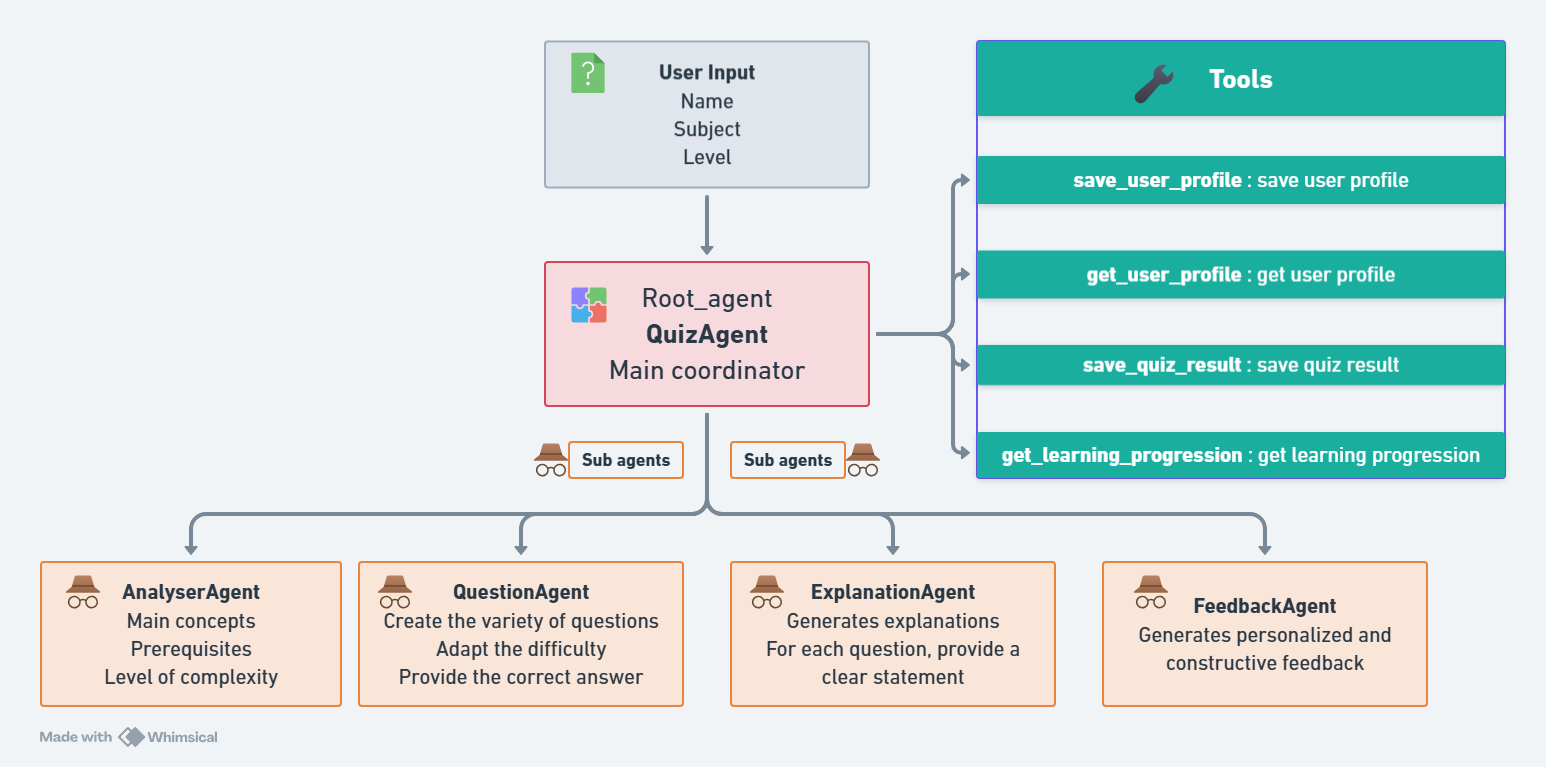

## 🏷️ Main features

- Control by a single prompt trainer.
- Automatic quiz generation from text or a theme.
- Automatic question categorization by difficulty.
- Adaptation to the target level (beginner/intermediate/advanced).
- Automatically generated feedback for each question or for the entire quiz.

## ✨ Benefits for Trainers

- Massive time savings on quiz creation.
- Improved pedagogical quality of assessments.
- Consistent question difficulty levels.
- Rich and immediate feedback ready to be integrated into a learning platform.
- Ease of use: no technical skills required.

**In summary**,

An automated solution enabling trainers to :
- Create high quality quizzes in seconds.
- Improve the pedagogical effectiveness of their modules.
- Offer more coherent and better calibrated learning.

 ## ⚙️Section 01 : Setup

### 1.1: Install dependencies
The Kaggle Notebooks environment includes a pre-installed version of the [google-adk](https://google.github.io/adk-docs/) library for Python and its required dependencies.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

```
pip install google-adk

In [ ]:
# pip install google-adk

### 1.2: Configure your Gemini API Key
This notebook uses the Gemini API, which requires an API key.

1. Get your API key

If you don't have one already, create an API key in Google AI Studio.

2. Add the key to Kaggle Secrets

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

In the top menu bar of the notebook editor, select Add-ons then Secrets.
Create a new secret with the label GOOGLE_API_KEY.
Paste your API key into the "Value" field and click "Save".
Ensure that the checkbox next to GOOGLE_API_KEY is selected so that the secret is attached to the notebook.
3. Authenticate in the notebook

Run the cell below to access the GOOGLE_API_KEY you just saved and set it as an environment variable for the notebook to use:

In [38]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


###  1.3: Import ADK components
Now, import the specific components you'll need from the Agent Development Kit and the Generative AI library. This keeps your code organized and ensures we have access to the necessary building blocks.

In [39]:
import os
import json

from google.genai import types  # For creating message Content/Parts
from typing import List, Dict, Any, Optional
from google.adk.agents import LlmAgent, Agent, SequentialAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import google_search, AgentTool, ToolContext
import asyncio
from google.adk.plugins.logging_plugin import LoggingPlugin

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


### 1.4: Helper functions
Helper function that prints the generated Python code and results from the code execution tool:

In [40]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None, 
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

✅ Helper functions defined.


### 1.5: Configure Retry Options
When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [41]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

## 🤖 Section 02 : Multi Agent System

### 2.1 Creation of Tools
Tools represent functions that agents can call to store user profile (name, level, weakness), track progression and persist quiz results. These are exposed to agents as callable actions.

In [42]:
def save_user_profile(
    tool_context: ToolContext,
    user_name: str,
    level: str,
    weakness: Optional[List[str]] = None
) -> Dict[str, Any]:
    """
    Saves the user's profile.
    
    Args:
        user_name: User's name
        level: Level (beginner, intermediate, advance)
        weakness: Weaknesses identified
    """
    tool_context.state["user:name"] = user_name
    tool_context.state["user:level"] = level
    tool_context.state["user:weakness"] = weakness or []
    
    return {
        "status": "success",
        "message": f"Profil's {user_name} recorded (level: {level})"
    }


In [43]:
def get_user_profile(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Retrieves the user's profile recorded.
    """
    return {
        "name": tool_context.state.get("user:name", "Unknown"),
        "level": tool_context.state.get("user:level", "Not specified"),
        "weakness": tool_context.state.get("user:weakness", [])
    }

In [44]:
def save_quiz_result(
    tool_context: ToolContext,
    quiz_id: str,
    score: float,
    total_questions: int,
    correct_answers: int,
    topics_mastered: Optional[List[str]] = None,
    topics_to_review: Optional[List[str]] = None
) -> Dict[str, Any]:
    """
    Saves the quiz results for a progress tracking.
    
    Args:
        quiz_id: Unique id quiz
        score: Score as a pourcentage (0-100)
        total_questions: Total number of questions
        correct_answers: Total number of correct questions
        topics_mastered: Topics mastered
        topics_to_review: Topics to review
    """
    # Retrieve the history
    history = tool_context.state.get("quiz:history", [])
    
    # Add new result (data)
    result = {
        "quiz_id": quiz_id,
        "score": score,
        "total_questions": total_questions,
        "correct_answers": correct_answers,
        "topics_mastered": topics_mastered,
        "topics_to_review": topics_to_review
    }
    history.append(result)
    
    # Record
    tool_context.state["quiz:history"] = history
    tool_context.state["quiz:last_score"] = score
    
    # Update the weaknesses
    current_weakness = tool_context.state.get("user:weakness", [])
    if topics_to_review:
        updated_weakness = list(set(current_weakness + topics_to_review))
        tool_context.state["user:weakness"] = updated_weakness
    
    return {
        "status": "success",
        "message": f"Results: {score}% ({correct_answers}/{total_questions})",
        "progression": len(history)
    }



In [45]:
def get_learning_progression(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Analyzes the user's progress based on their quiz history.
    """
    history = tool_context.state.get("quiz:history", [])
    
    if not history:
        return {
            "status": "no_data",
            "message": "No quizzes in progress"
        }
    
    # Calculation of statistics
    total_quizzes = len(history)
    avg_score = sum(q["score"] for q in history) / total_quizzes
    last_3_scores = [q["score"] for q in history[-3:]]
    
    # Trend Analysis
    if len(last_3_scores) >= 2:
        trend = "Improvement" if last_3_scores[-1] > last_3_scores[0] else "No change"
    else:
        trend = "Beginning"
    
    # Identifier les sujets récurrents à revoir
    all_weak_topics = []
    for quiz in history:
        all_weak_topics.extend(quiz.get("topics_to_review", []))
    
    from collections import Counter
    weak_topics_count = Counter(all_weak_topics)
    recurring_weaknesses = [topic for topic, count in weak_topics_count.items() if count >= 2]
    
    return {
        "total_quizzes": total_quizzes,
        "average_score": round(avg_score, 1),
        "last_score": history[-1]["score"],
        "trend": trend,
        "recurring_weaknesses": recurring_weaknesses,
        "last_3_scores": last_3_scores
    }

### 2.2 Creation of Agents
Each agent has a specialized role:
 - AnalyserAgent: Analyzes and extracts the main concepts.
 - QuestionAgent: Builds different types of questions and exercices.
 - ExplanationAgent: Generates explanations.
 - FeedbackAgent: Generates feedback.
 - QuizAgent : Root agent, it is the orchestrator (type LLmAgent but could be a SequentialAgent for greater efficiency) 
 Each agent is defined by its prompt, capabilities, and output expectations.

In [46]:
# Analyser Agent : Analyzes the content to identify the most relevant concepts for the future evaluation
analyser_agent = LlmAgent(
    name="AnalyserAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Analyzes the subject of study and identifies the key concepts to be evaluated.",
    instruction="""You are an expert in instructional analysis.
When given a topic for study:
1. Identify the 5-7 main concepts to master
2. Determine the necessary prerequisites
3. Suggest a logical learning progression
4. Evaluate the complexity of the topic

Format your response in a structured way with:
- Main concepts (list)
- Prerequisites (list)
- Suggested progression (numbered steps)
- Level of complexity (beginner/intermediate/advanced)
Use your existing knowledge to analyze the topic thoroughly.""",
   #tools=[google_search], # more efficient but leads to an error...
   output_key="analysis_findings"  # The result of this agent will be stored in the session state with this key.
)

print("✅ analyser_agent.")

✅ analyser_agent.


In [47]:
# Question Agent : Generates questions and exercises adapted to the user's level
question_agent = LlmAgent(
    name="QuestionAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Generates questions and exercises adapted to the user's level.",
    instruction="""You are an expert in creating educational quizzes.
Create a variety of questions:
1. True/False with justification
2. Single choice question (4 choices, 1 correct answer)
3. Multiple choice question (4 choices, 2 correct answers)
4. Simple practical exercises
5. Evaluate the complexity of the topic

Adapt the difficulty to the user's level:
- Beginner: basic comprehension questions
- Intermediate: application questions
- Advanced: analysis and synthesis questions

For each question, provide:
- A clear statement
- The options (if multiple choice)
- The correct answer
- A brief explanation
- The concept being tested
- The difficulty level (1-5).""",
    
    output_key="generated_questions"  # The result of this agent will be stored in the session state with this key.
)

print("✅ question_agent.")

✅ question_agent.


In [48]:
# Explanation Agent : Generates explanation to the user
explanation_agent = LlmAgent(
    name="ExplanationAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Generates detailed and educational explanations.",
    instruction="""You are an expert in pedagogy.
Generates explanations that:
1. Are adapted to the user's level.
2. Use concrete examples.
3. Offer relevant analogies.
4. Break down complex concepts in a simple way.
5. Include mnemonic devices if useful.

Adapt the difficulty to the user's level:
- Beginner: basic comprehension questions.
- Intermediate: application questions.
- Advanced: analysis and synthesis questions.

For each question, provide:
- A clear statement.
- The options (if multiple choice).
- The correct answer.
- A brief explanation.
- The concept being tested.
- The difficulty level (1-5).

Keep your tone encouraging and positive.""",
    
    output_key="generated_explanation"  # The result of this agent will be stored in the session state with this key.
)

print("✅ explanation_agent.")

✅ explanation_agent.


In [49]:
# Feedback Agent : Coach the user with personalized and constructive feedback
feedback_agent = LlmAgent(
    name="FeedbackAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Generates personalized and constructive feedback.",
    instruction="""You are a supportive learning coach.
Analyze the user's performance and provide:
1. Positive feedback on successes.
2. Constructive analysis of errors.
3. Targeted improvement tips.
4. Revision recommendations.
5. An action plan for the next steps.

Your feedback should be:
- Encouraging and motivating.
- Positive and constructive.
- Specific and actionable.
- Adapted to the user's level.
- Progress-oriented.

Highlight strengths before areas for improvement.""",
    
    output_key="generated_feedback"  # The result of this agent will be stored in the session state with this key.
)

print("✅ feedback_agent.")

✅ feedback_agent.


Root_agent coordinates all other agents. It determines the execution, order, aggregates outputs, ensures alignment between difficulty tiers.

In [50]:
# Root Agent: Orchestrates the workflow by calling the sub-agents as tools. 
# SequentialAgent would be much better than LlmAgent for coordination but intelligent and contextual decision-making was prioritized.
root_agent = LlmAgent(
    name="QuizAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Main coordinator.",
    instruction="""You are the main coordinator of the quiz generation system..
 You must follow these steps:
1. Start by saving the user's profile with `save_user_profile` if new information is provided.
2. Use `analyser_agent` to analyze the requested topic.
3. Use `question_agent` to create appropriate questions.
4. Use `explanation_agent` for additional explanations.
5. After a quiz, use `feedback_agent` for personalized feedback.
6. Save the results with `save_quiz_result`.
7. Consult `get_learning_progression` to adjust the difficulty.
8. Use `get_user_profile` to personalize the experience.


Be proactive in personalizing and tracking progress.""",
    
   tools=[
        save_user_profile,
        get_user_profile,
        save_quiz_result,
        # google_search,
        get_learning_progression       
    ],
    sub_agents=[
        analyser_agent,
        question_agent,
        explanation_agent,
        feedback_agent
    ]
)

print("✅ root_agent created.")

✅ root_agent created.


### 2.3 Creation of System

In [51]:
class QuizGeneratorSystem:
    """Quiz generation system

    This class centralizes:
    - Application identification (app_name, user)
    - Session management (creation/retrieval)
    - Memory persistence
    - Interaction with the Root Agent through ADK's Runner
    
    
    The intent is to provide a clean, maintainable API that separates concerns:
    - The agents handle reasoning and quiz construction
    - The Runner handles message routing and execution    
    """
    
    def __init__(self):
        # configuration identifiers
        self.app_name = "quiz_generator_app"
        self.user_id = "user_01"
        
        # Services
        # In-memory implementations of the session and memory layers
        # In production, a database storage could be used
        self.session_service = InMemorySessionService()
        self.memory_service = InMemoryMemoryService()
        
        # Runner with plugin de logging
        # The LoggingPlugin captures diagnostic information
        self.runner = Runner(
            agent=root_agent,
            app_name=self.app_name,
            session_service=self.session_service,
            memory_service=self.memory_service,
            plugins=[LoggingPlugin()] # useful for debugging
        )

    
    # SESSION CREATION / RETRIEVAL
    async def create_session(self, session_id: str = None):
        """Create or retrieve a session"""
        if not session_id:
            import uuid
            session_id = f"session_{uuid.uuid4().hex[:8]}"
        
        try:
            # Attempt session creation 
            session = await self.session_service.create_session(
                app_name=self.app_name,
                user_id=self.user_id,
                session_id=session_id
            )
        except:
            # If creation fails (likely because the ID exists), fetch instead
            session = await self.session_service.get_session(
                app_name=self.app_name,
                user_id=self.user_id,
                session_id=session_id
            )
        
        return session

    
    # MAIN EXECUTION     
    async def run(self, user_query: str, session_id: str = None):
        """
        User request
        
        Args:
            user_query: User's question
            session_id: Id session (will be creade if none)
        """
        # Create or retrieve the session
        session = await self.create_session(session_id)
        
        # User's query
        query_content = types.Content(
            role="user",
            parts=[types.Part(text=user_query)]
        )
        
        print(f"\n{'='*60}")
        print(f"User > {user_query}")
        print(f"{'='*60}\n")
        
        # Run and display the responses
        async for event in self.runner.run_async(
            user_id=self.user_id,
            session_id=session.id,
            new_message=query_content
        ):
            if event.is_final_response() and event.content and event.content.parts:
                for part in event.content.parts:
                    if hasattr(part, 'text') and part.text and part.text != "None":
                        print(f"Assistant > {part.text}\n")
        
        print(f"{'='*60}\n")
        
        # Save the session to memory
        await self.memory_service.add_session_to_memory(session)
        
        return session.id


In [52]:
import logging
class _NoFunctionCallWarning(logging.Filter):
    def filter(self, record: logging.LogRecord) -> bool:
        message = record.getMessage()
        if "there are non-text parts in the response:" in message:
            return False
        else:
            return True

logging.getLogger("google_genai.types").addFilter(_NoFunctionCallWarning())

### 2.4 Running a demo

In [53]:
# Run a demo
async def demo_simple():
    """Example of use"""
    
    system = QuizGeneratorSystem()
    
    await system.run(
        "Je suis Lana, niveau débutant. Crée-moi un quiz sur l'intelligence artificielle'(5 questions)."
    )

In [57]:
if __name__ == "__main__":
    import asyncio      
   
    choice = input("\nType 1 to start the session: ").strip()
    
    if choice == "1":
       if choice == "1":
        await demo_simple()
    else:
        print("\nType 1 to start the session, please")


Type 1 to start the session:  1



User > Je suis Lana, niveau débutant. Crée-moi un quiz sur l'intelligence artificielle'(5 questions).

[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-ef694b0b-ab2d-4d76-a537-6477bf784074
[logging_plugin]    Session ID: session_f325b982
[logging_plugin]    User ID: user_01
[logging_plugin]    App Name: quiz_generator_app
[logging_plugin]    Root Agent: QuizAgent
[logging_plugin]    User Content: text: 'Je suis Lana, niveau débutant. Crée-moi un quiz sur l'intelligence artificielle'(5 questions).'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-ef694b0b-ab2d-4d76-a537-6477bf784074
[logging_plugin]    Starting Agent: QuizAgent
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: QuizAgent
[logging_plugin]    Invocation ID: e-ef694b0b-ab2d-4d76-a537-6477bf784074
[logging_plugin] 🧠 LLM REQUEST
[logging_plugin]    Model: gemini-2.5-flash-lite
[logging_plugin]    Agent: QuizAgent
[logging_plugin]    System Instruction: '

In [56]:
# Run the system
result = await demo_simple()
if result and result['quiz_content']:
    print(result['quiz_content'])
else:
    print("Aucun quiz généré")


User > Je suis Lana, niveau débutant. Crée-moi un quiz sur l'intelligence artificielle'(5 questions).

[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-778512f6-22dc-40a5-a09c-67b2c473b5f8
[logging_plugin]    Session ID: session_b662a257
[logging_plugin]    User ID: user_01
[logging_plugin]    App Name: quiz_generator_app
[logging_plugin]    Root Agent: QuizAgent
[logging_plugin]    User Content: text: 'Je suis Lana, niveau débutant. Crée-moi un quiz sur l'intelligence artificielle'(5 questions).'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-778512f6-22dc-40a5-a09c-67b2c473b5f8
[logging_plugin]    Starting Agent: QuizAgent
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: QuizAgent
[logging_plugin]    Invocation ID: e-778512f6-22dc-40a5-a09c-67b2c473b5f8
[logging_plugin] 🧠 LLM REQUEST
[logging_plugin]    Model: gemini-2.5-flash-lite
[logging_plugin]    Agent: QuizAgent
[logging_plugin]    System Instruction: '

## 💻 Section 03 : Use of the ADK web interface ( ADK Web UI)

In [58]:
import logging
import os

# Clean up any previous logs
for log_file in ["logger.log", "web.log", "tunnel.log"]:
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Cleaned up {log_file}")

# Configure logging with DEBUG log level.
logging.basicConfig(
    filename="logger.log",
    level=logging.DEBUG,
    format="%(filename)s:%(lineno)s %(levelname)s:%(message)s",
)

In [59]:
# Clean up any previous logs
for log_file in ["logger.log", "web.log", "tunnel.log"]:
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Cleaned up {log_file}")

# Configure logging with DEBUG log level.
logging.basicConfig(
    filename="logger.log",
    level=logging.DEBUG,
    format="%(filename)s:%(lineno)s %(levelname)s:%(message)s",
)

print("✅ Logging configured")

✅ Logging configured


We'll use a proxy to access the ADK web UI from within the Kaggle Notebooks environment. If you are running this outside the Kaggle environment, you don't need to do this.

In [60]:
from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers


# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [61]:
# Run the adk create CLI command to set up the project scaffolding.
!adk create quiz-agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY


Agent created in /kaggle/working/quiz-agent:
- .env
- __init__.py
- agent.py



Write the following code block to a file located at: quiz-agent/agent.py

In [66]:
%%writefile quiz-agent/agent.py

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools.google_search_tool import google_search
from google.genai import types
from typing import List, Dict, Any, Optional


# Configuration de retry
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# Définition des outils
def save_user_profile(
    tool_context: ToolContext,
    user_name: str,
    level: str,
    weakness: Optional[List[str]] = None
) -> Dict[str, Any]:
    """
    Saves the user's profile.
    
    Args:
        user_name: User's name
        level: Level (beginner, intermediate, advance)
        weakness: Weaknesses identified
    """
    tool_context.state["user:name"] = user_name
    tool_context.state["user:level"] = level
    tool_context.state["user:weakness"] = weakness or []
    
    return {
        "status": "success",
        "message": f"Profil's {user_name} recorded (level: {level})"
    }

def get_user_profile(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Retrieves the user's profile recorded.
    """
    return {
        "name": tool_context.state.get("user:name", "Unknown"),
        "level": tool_context.state.get("user:level", "Not specified"),
        "weakness": tool_context.state.get("user:weakness", [])
    }

def save_quiz_result(
    tool_context: ToolContext,
    quiz_id: str,
    score: float,
    total_questions: int,
    correct_answers: int,
    topics_mastered: Optional[List[str]] = None,
    topics_to_review: Optional[List[str]] = None
) -> Dict[str, Any]:
    """
    Saves the quiz results for a progress tracking.
    """
    history = tool_context.state.get("quiz:history", [])
    
    result = {
        "quiz_id": quiz_id,
        "score": score,
        "total_questions": total_questions,
        "correct_answers": correct_answers,
        "topics_mastered": topics_mastered,
        "topics_to_review": topics_to_review
    }
    history.append(result)
    
    tool_context.state["quiz:history"] = history
    tool_context.state["quiz:last_score"] = score
    
    current_weakness = tool_context.state.get("user:weakness", [])
    if topics_to_review:
        updated_weakness = list(set(current_weakness + topics_to_review))
        tool_context.state["user:weakness"] = updated_weakness
    
    return {
        "status": "success",
        "message": f"Results: {score}% ({correct_answers}/{total_questions})",
        "progression": len(history)
    }

def get_learning_progression(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Analyzes the user's progress based on their quiz history.
    """
    history = tool_context.state.get("quiz:history", [])
    
    if not history:
        return {
            "status": "no_data",
            "message": "No quizzes in progress"
        }
    
    total_quizzes = len(history)
    avg_score = sum(q["score"] for q in history) / total_quizzes
    last_3_scores = [q["score"] for q in history[-3:]]
    
    if len(last_3_scores) >= 2:
        trend = "Improvement" if last_3_scores[-1] > last_3_scores[0] else "No change"
    else:
        trend = "Beginning"
    
    all_weak_topics = []
    for quiz in history:
        all_weak_topics.extend(quiz.get("topics_to_review", []))
    
    from collections import Counter
    weak_topics_count = Counter(all_weak_topics)
    recurring_weaknesses = [topic for topic, count in weak_topics_count.items() if count >= 2]
    
    return {
        "total_quizzes": total_quizzes,
        "average_score": round(avg_score, 1),
        "last_score": history[-1]["score"],
        "trend": trend,
        "recurring_weaknesses": recurring_weaknesses,
        "last_3_scores": last_3_scores
    }

# Définition des agents
analyser_agent = LlmAgent(
    name="AnalyserAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Analyzes the subject of study and identifies the key concepts to be evaluated.",
    instruction="""You are an expert in instructional analysis.
When given a topic for study:
1. Identify the 5-7 main concepts to master
2. Determine the necessary prerequisites
3. Suggest a logical learning progression
4. Evaluate the complexity of the topic

Format your response in a structured way with:
- Main concepts (list)
- Prerequisites (list)
- Suggested progression (numbered steps)
- Level of complexity (beginner/intermediate/advanced)
Use your existing knowledge to analyze the topic thoroughly.""",
    output_key="analysis_findings"
)

question_agent = LlmAgent(
    name="QuestionAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Generates questions and exercises adapted to the user's level.",
    instruction="""You are an expert in creating educational quizzes.
Create a variety of questions:
1. True/False with justification
2. Single choice question (4 choices, 1 correct answer)
3. Multiple choice question (4 choices, 2 correct answers)
4. Simple practical exercises
5. Evaluate the complexity of the topic

Adapt the difficulty to the user's level:
- Beginner: basic comprehension questions
- Intermediate: application questions
- Advanced: analysis and synthesis questions

For each question, provide:
- A clear statement
- The options (if multiple choice)
- The correct answer
- A brief explanation
- The concept being tested
- The difficulty level (1-5).""",
    output_key="generated_questions"
)

explanation_agent = LlmAgent(
    name="ExplanationAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Generates detailed and educational explanations.",
    instruction="""You are an expert in pedagogy.
Generates explanations that:
1. Are adapted to the user's level.
2. Use concrete examples.
3. Offer relevant analogies.
4. Break down complex concepts in a simple way.
5. Include mnemonic devices if useful.

Keep your tone encouraging and positive.""",
    output_key="generated_explanation"
)

feedback_agent = LlmAgent(
    name="FeedbackAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Generates personalized and constructive feedback.",
    instruction="""You are a supportive learning coach.
Analyze the user's performance and provide:
1. Positive feedback on successes.
2. Constructive analysis of errors.
3. Targeted improvement tips.
4. Revision recommendations.
5. An action plan for the next steps.

Your feedback should be:
- Encouraging and motivating.
- Positive and constructive.
- Specific and actionable.
- Adapted to the user's level.
- Progress-oriented.

Highlight strengths before areas for improvement.""",
    output_key="generated_feedback"
)

# ROOT AGENT - C'est la variable que l'ADK Web UI cherche !
root_agent = LlmAgent(
    name="QuizAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Main coordinator.",
    instruction="""You are the main coordinator of the quiz generation system.
You must follow these steps:
1. Start by saving the user's profile with `save_user_profile` if new information is provided.
2. Use `analyser_agent` to analyze the requested topic.
3. Use `question_agent` to create appropriate questions.
4. Use `explanation_agent` for additional explanations.
5. After a quiz, use `feedback_agent` for personalized feedback.
6. Save the results with `save_quiz_result`.
7. Consult `get_learning_progression` to adjust the difficulty.
8. Use `get_user_profile` to personalize the experience.

Be proactive in personalizing and tracking progress.""",
    tools=[
        save_user_profile,
        get_user_profile,
        save_quiz_result,
        get_learning_progression
    ],
    sub_agents=[
        analyser_agent,
        question_agent,
        explanation_agent,
        feedback_agent
    ]
)

Overwriting quiz-agent/agent.py


In [26]:
# Get the proxied URL to access the ADK web UI in the Kaggle Notebooks environment:
url_prefix = get_adk_proxy_url()

Now you can start the ADK web UI using the following command.

👉 Note: The following cell will not "complete", but will remain running and serving the ADK web UI until you manually stop the cell.

In [ ]:
!adk web --url_prefix {url_prefix}

Once the ADK web UI starts, open the proxy link using the button in the previous cell.

‼️ IMPORTANT: DO NOT SHARE THE PROXY LINK with anyone - treat it as sensitive data as it contains your authentication token in the URL.

### Illustrations with ADK Web UI

Each agent's reasoning is presented to the trainer for a better understanding of the quiz's construction.

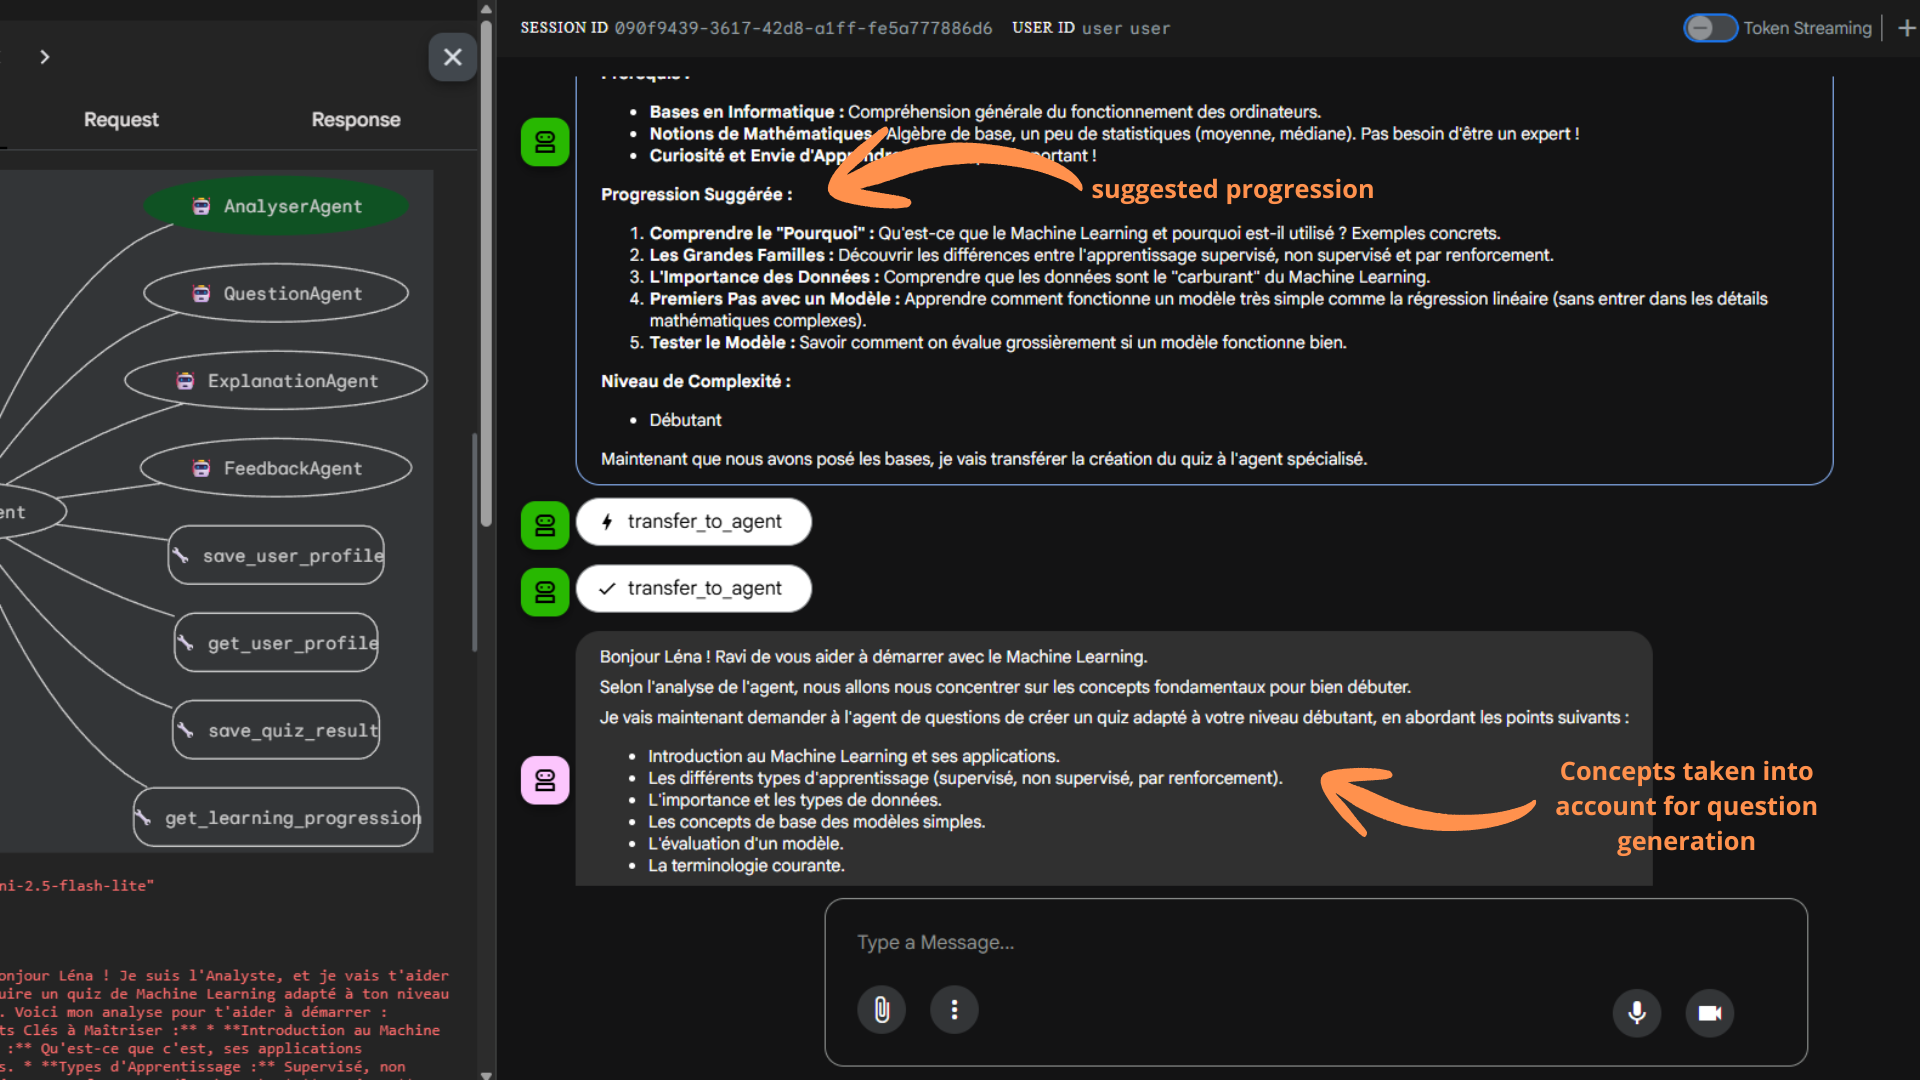

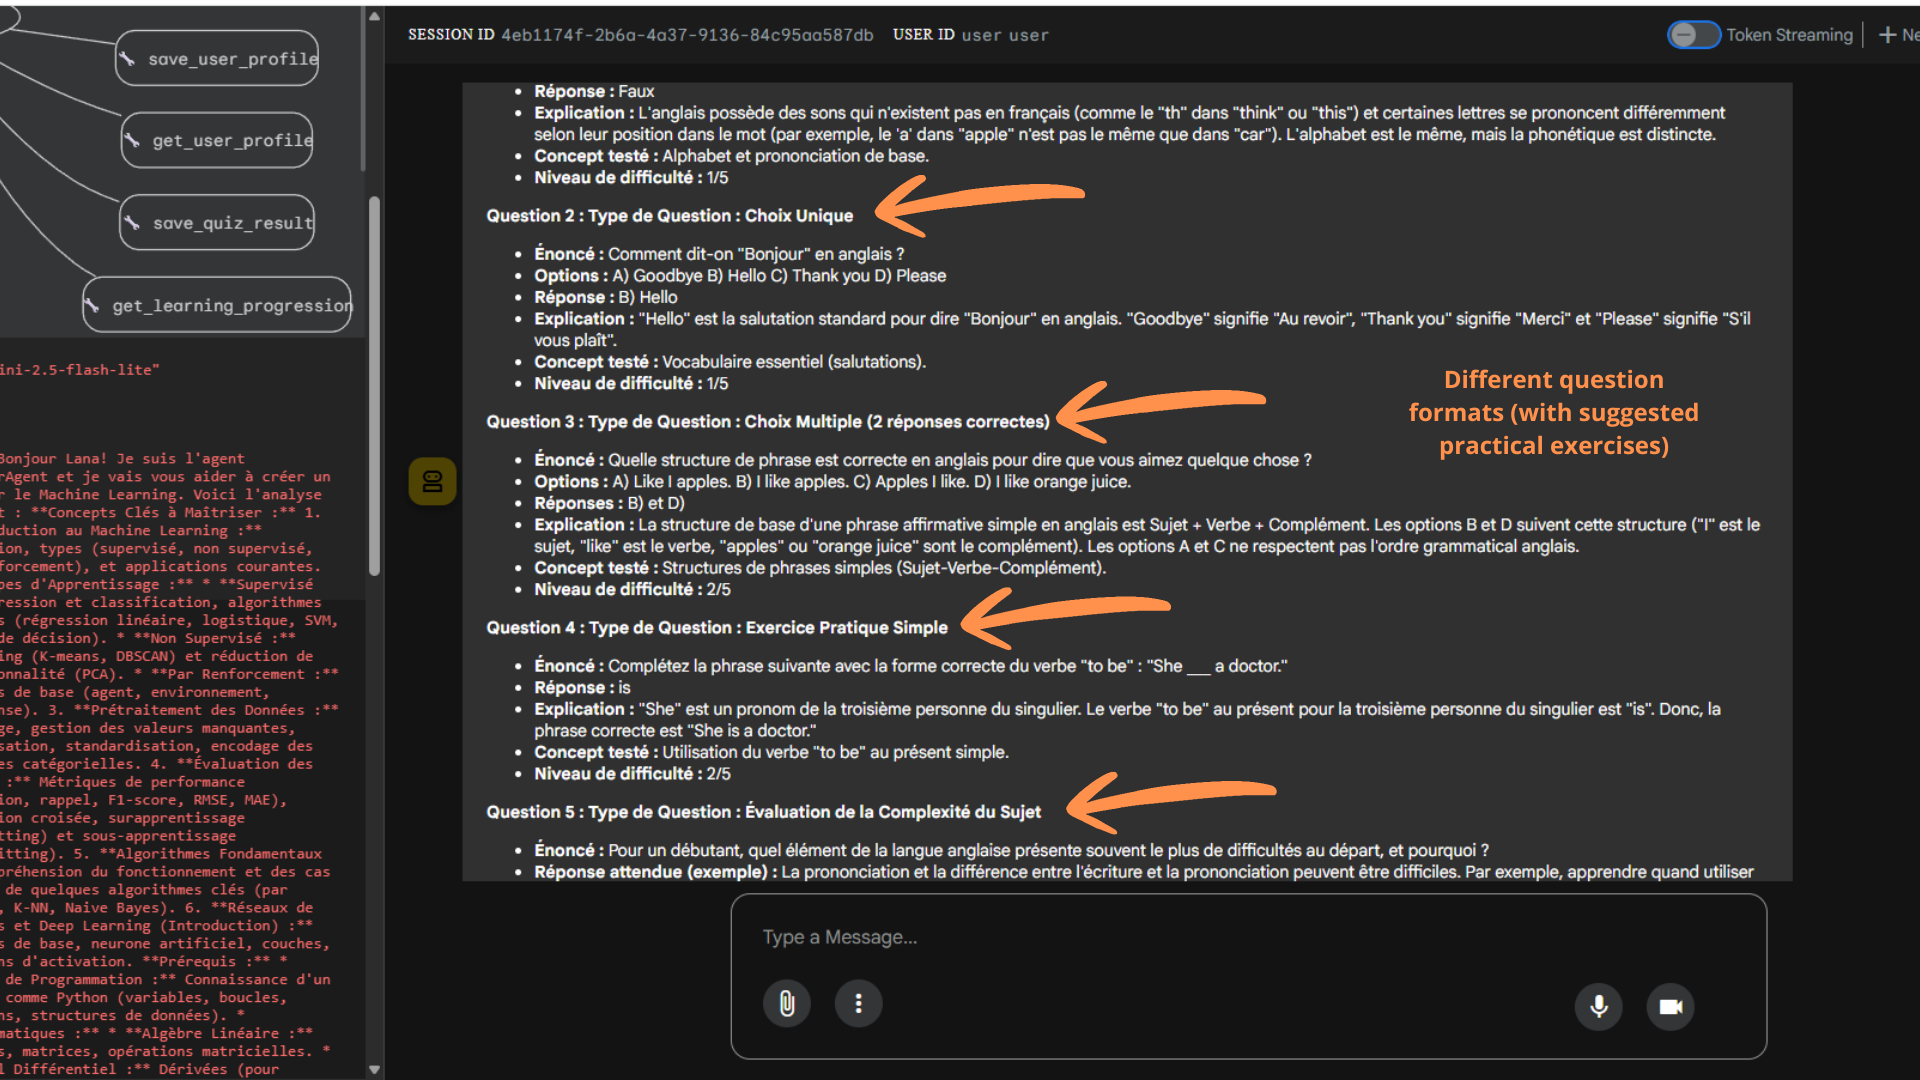

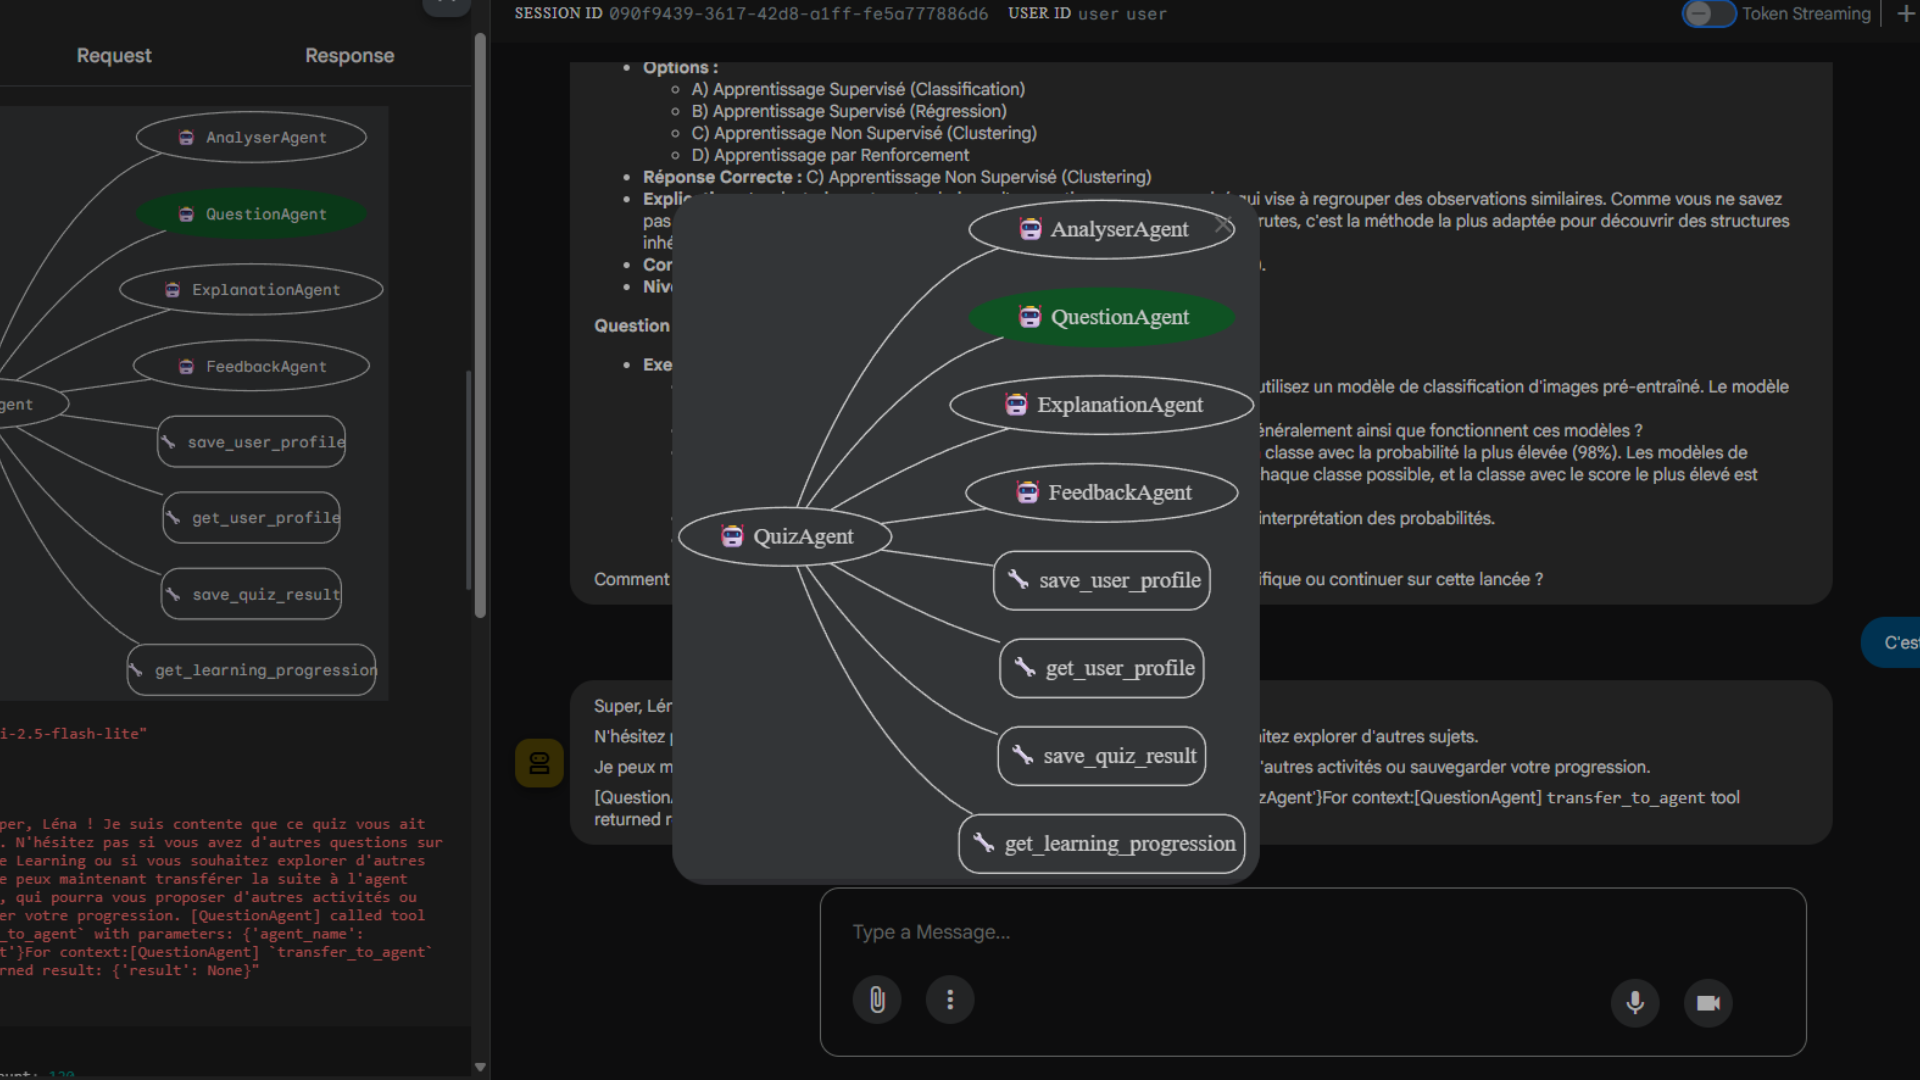